In [1]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models Regression
import lightgbm as lgb

# Models Classification
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Misc
import math
import shap
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin


import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Utils

In [2]:
def scoringProfit(yTrue, pred, doubleAnalysis = False):
    '''
        Custrom metric to compute profit where TP = 90 and
        FP = -10 in generating the metric
        
        Args:
            yTrue: Array with ground truth
            pred: Array with predict from model
            doubleAnalysis: Boolean to say if return one metric or two
            
        Returns:
            Scorer: Scorer of  profit by customer or 
                    profit by customer and all profit
    '''
    
    # ### Matriz de confusão com (tn,fp,fn,tp)
    crosstab = metrics.confusion_matrix(yTrue, pred)
    
    if len(pred) < 4:
        tn, fp, fn, tp = 0, 0, 0, 0
    else:
        tn, fp, fn, tp = crosstab.ravel()
    
    # Compute profit
    profit = (tp*90 - fp*10)
    
    # Compute profit per customer
    profitCustomer = profit/len(pred)

    if doubleAnalysis:
        return profitCustomer, profit
        
    return profitCustomer



In [3]:
def thresholdsCurve(y_true = None, y_proba = None):
  '''
      Calculate the best threshold to maximize profit
      
      Args:
        y_true (np.array):
        y_proba (np.array):
  '''
    
  thresholds = np.arange(0.0, 1.0, 0.01)
  threshold_gain_max = 0.0

  gain_score_eval = list()
  gain_score_max = 0.0

  gain_tp = 90
  gain_fp = -10

  for threshold in thresholds:
    y_pred = np.array(list(map(lambda proba: 1 if proba >= threshold else 0, y_proba[:, 1])))
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    total_clientes = int(tp + tn + fp + fn)
    gain = round((tp * gain_tp + fp * gain_fp) / total_clientes, 2)

    gain_score_eval.append(gain)

    if gain >= gain_score_max and threshold >= threshold_gain_max:
      gain_score_max = gain
      threshold_gain_max = threshold
  
  plt.figure(figsize= (5, 5))
  sns.lineplot(x = thresholds, y = gain_score_eval, color= "red")

  plt.text(x = 0.45,
           y = gain_score_max*1.1,
           s = f"THRESHOLD: {threshold_gain_max:.2f},\nLucro Per. Cliente (R$): {gain_score_max:.2f}", 
           bbox = {'facecolor': 'gray','alpha': 0.4, 'pad': 6}
  )

  plt.title("Curva Lucro Per. Cliente(R$) x THRESHOLD")
  plt.legend(["Classe 1 - Insatisfeito"])
  plt.ylim(0, gain_score_max*1.35)
  plt.ylabel("Lucro Per. Cliente(R$)")
  plt.xlabel("Thresholds")
  plt.show()

# Carregamento dos Dados

In [6]:
dfTrain = pd.read_csv('train_features.csv')
#yTrain = dfTrain.TARGET
#dfTrain = dfTrain.drop(labels=['TARGET'], axis=1)

dfVal = pd.read_csv('val_features.csv')
yVal = dfVal.TARGET
dfVal = dfVal.drop(labels=['TARGET'], axis=1)

dfTest = pd.read_csv('test_features.csv')

In [7]:
# ### Drop duplicated rows
def dropDuplicatedRows(df, cols, keep=False):
    print(f'Dataset antes do processamento: {df.shape}')
    dfResult = df.drop_duplicates(subset=cols, inplace=False,keep=keep)
    print(f'Dataset após o processamento: {dfResult.shape}')
    return dfResult

# ### Remove duplicated Data and keep one element
dfTrain = dropDuplicatedRows(dfTrain, dfTrain.columns, 'last')

Dataset antes do processamento: (56757, 26)
Dataset após o processamento: (55706, 26)


In [8]:
# Remove All Duplicated elements where the target is different
dfTrain = dropDuplicatedRows(dfTrain, dfTrain.columns.drop('TARGET'))

Dataset antes do processamento: (55706, 26)
Dataset após o processamento: (55626, 26)


In [9]:
yTrain = dfTrain.TARGET
dfTrain = dfTrain.drop(labels=['TARGET'], axis=1)

# Solução

# 1.0 - Classificação (Case A)

## 1.1 - Preparação do Dataset

In [10]:
modelTransform = Pipeline(
                 [
                    ('scale', PowerTransformer(method='yeo-johnson'))
                ]
            )
modelTransform.fit(dfTrain, yTrain)

Pipeline(steps=[('scale', PowerTransformer())])

In [11]:
dfTrainCLF = modelTransform.transform(dfTrain)
dfValCLF = modelTransform.transform(dfVal)
dfTestCLF = modelTransform.transform(dfTest)

## 1.2 - Ponto de Partida

In [14]:
# Model base
clRF = RandomForestClassifier(n_jobs = -1, class_weight='balanced')
clRF.fit(dfTrainCLF, yTrain)
preds = clRF.predict(dfValCLF)
rfPerCustomer, rfProfit = scoringProfit(yVal, preds, True)

# Lucro caso a campanha impacte todos os clientes
allCustomerProfitPerCustomer, allCustomerProfit = scoringProfit(yVal, [1 for i in range(len(yVal))], True)

# Verificação do score máximo possível no treino
maxProfitPerCustomer, maxProfit = (scoringProfit(yVal, yVal, True))

print(f"Lucro no modelo base R${rfProfit:,.2f}")
print(f"Lucro por cliente no modelo base R$ {rfPerCustomer:,.2f}\n")

print(f"Lucro caso a capanha seja aplicada a todos os clientes R$ {allCustomerProfit:,.2f}")
print(f"Lucro por cliente caso a capanha seja aplicada a todos os clientes R$ {allCustomerProfitPerCustomer:,.2f}\n")

print(f"Lucro caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ {maxProfit:,.2f}")
print(f"Lucro por cliente caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ {maxProfitPerCustomer:,.2f}")

Lucro no modelo base R$1,110.00
Lucro por cliente no modelo base R$ 0.08

Lucro caso a capanha seja aplicada a todos os clientes R$ -88,300.00
Lucro por cliente caso a capanha seja aplicada a todos os clientes R$ -6.22

Lucro caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ 48,240.00
Lucro por cliente caso a capanha seja aplicada apenas aos clientes insatisfeitos R$ 3.40


## 1.3 - Busca dos Melhores Parâmetros

### 1.3.0 - LGBM

In [15]:
def objective(params):
    classifier = lgb.LGBMClassifier(verbose = -1, 
                                    n_jobs = -1, 
                                    class_weight='balanced',
                                    objective='binary', 
                                    random_state=424, **params)

    model = Pipeline(
                 [
                    ('classifier', classifier)
                ]
            )
    
    model.fit(dfTrainCLF, yTrain)

    yPred = classifier.predict(dfValCLF)

    score = scoringProfit(yVal, yPred)

    return {
        'loss': -score,
        'status': STATUS_OK, 
    }

In [16]:
spaceLGBM = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 50, 5000)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.35, 0.02)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 20, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 3, 20, 1)),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'reg_lambda': hp.lognormal('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.lognormal('reg_alpha', 0.0, 1.0),

}

In [17]:
trials = Trials ()

bestParamsLGBM = fmin(
    fn=objective,
    space=spaceLGBM,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

100%|██| 1000/1000 [1:20:45<00:00,  4.85s/trial, best loss: -0.8393234672304439]


In [18]:
print(bestParamsLGBM)

{'colsample_bytree': 0.30059620663011166, 'learning_rate': 9, 'max_depth': 15.0, 'min_child_weight': 11.0, 'n_estimators': 2086.018317405905, 'reg_alpha': 4.244012097757892, 'reg_lambda': 0.8367600495270754, 'subsample': 0.42304664866364106}


### 1.3.1 - XGBoost

In [19]:
def objective(params):
    classifier = XGBClassifier(n_jobs = -1, objective='binary:logistic', random_state=424, **params)

    model = Pipeline(
                 [
                    ('classifier', classifier)
                ]
            )
    model.fit(dfTrainCLF, yTrain)

    yPred = classifier.predict(dfValCLF)

    score = scoringProfit(yVal, yPred)

    return {
        'loss': -score,
        'status': STATUS_OK, 
        'booster': model.named_steps['classifier'].get_booster().attributes()
    }

In [20]:
spaceXGB = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 50, 5000)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.35, 0.02)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 20, 1)),
    'scale_pos_weight': scope.int(hp.quniform('scale_pos_weight', 20, 30, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 3, 20, 1)),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'reg_lambda': hp.lognormal('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.lognormal('reg_alpha', 0.0, 1.0)
}

In [21]:
trials = Trials ()

bestParamsXGB = fmin(
    fn=objective,
    space=spaceXGB,
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000
)

100%|████| 1000/1000 [51:12<00:00,  3.07s/trial, best loss: -0.9337561663143058]


In [22]:
print(bestParamsXGB)

{'colsample_bytree': 0.42807200164598436, 'learning_rate': 0, 'max_depth': 8.0, 'min_child_weight': 4.0, 'n_estimators': 455.9947203498623, 'reg_alpha': 0.1786644230286853, 'reg_lambda': 0.12358504484040327, 'scale_pos_weight': 20.0, 'subsample': 0.8142763796276121}


In [23]:
print(trials.best_trial['result'])

{'loss': -0.9337561663143058, 'status': 'ok', 'booster': {}}


## 1.4 - Avaliar Melhor Modelo

### 1.4.0 - XGBoost

In [24]:
bestParamsXGB['learning_rate'] = np.arange(0.05, 0.35, 0.02)[0]
bestParamsXGB['n_estimators'] = int(bestParamsXGB['n_estimators'])
bestParamsXGB['max_depth'] = int(bestParamsXGB['max_depth'])

In [25]:
classifierXGB = XGBClassifier(n_jobs = -1, objective='binary:logistic', random_state=424, **bestParamsXGB)
classifierXGB.fit(dfTrainCLF, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.42807200164598436, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=4.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=455, n_jobs=-1,
              num_parallel_tree=None, random_state=424, ...)

In [26]:
yPred_prob = classifierXGB.predict_proba(dfValCLF)

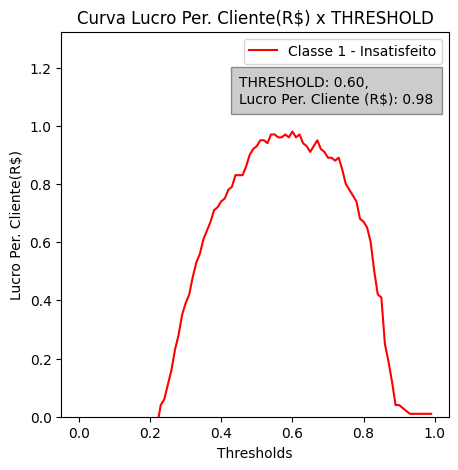

In [27]:
thresholdsCurve(yVal, yPred_prob)

### 1.4.1 - LGBM

In [28]:
bestParamsLGBM['learning_rate'] = np.arange(0.05, 0.35, 0.02)[9]
bestParamsLGBM['n_estimators'] = int(bestParamsLGBM['n_estimators'])
bestParamsLGBM['max_depth'] = int(bestParamsLGBM['max_depth'])

In [29]:
classifierLGBM = lgb.LGBMClassifier(verbose = -1, 
                                    n_jobs = -1, 
                                    objective='binary', 
                                    random_state=424, 
                                    **bestParamsLGBM)

In [30]:
classifierLGBM.fit(dfTrainCLF, yTrain)

LGBMClassifier(colsample_bytree=0.30059620663011166,
               learning_rate=0.23000000000000004, max_depth=15,
               min_child_weight=11.0, n_estimators=2086, n_jobs=-1,
               objective='binary', random_state=424,
               reg_alpha=4.244012097757892, reg_lambda=0.8367600495270754,
               subsample=0.42304664866364106, verbose=-1)

In [31]:
yPred_prob = classifierLGBM.predict_proba(dfValCLF)

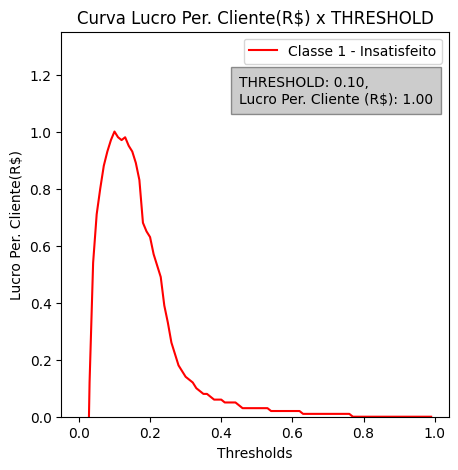

In [32]:
thresholdsCurve(yVal, yPred_prob)

In [33]:
yPred = yPred_prob[:,1] > 0.10
profitClient, profit = scoringProfit(yVal, yPred, True)
profitClientMax, profitMax = scoringProfit(yVal, yVal, True)

print(f'Lucro máximo por cliente {profitClient:,.2f}')
print(f'Lucro máximo da campanha: R$ {profit:,.2f}')
print(f'Lucro máximo que poderia ser atingindo na campanha: R$ {profitMax:,.2f}')
print(f'Lucro máximo em %: {profit/profitMax:.2%}')

Lucro máximo por cliente 1.00
Lucro máximo da campanha: R$ 14,240.00
Lucro máximo que poderia ser atingindo na campanha: R$ 48,240.00
Lucro máximo em %: 29.52%


## 1.5 - Explicabilidade do Melhor Modelo (SHAP Values)

In [34]:
shap.initjs()
explainer = shap.TreeExplainer(classifierLGBM)
shap_values = explainer.shap_values(dfValCLF)

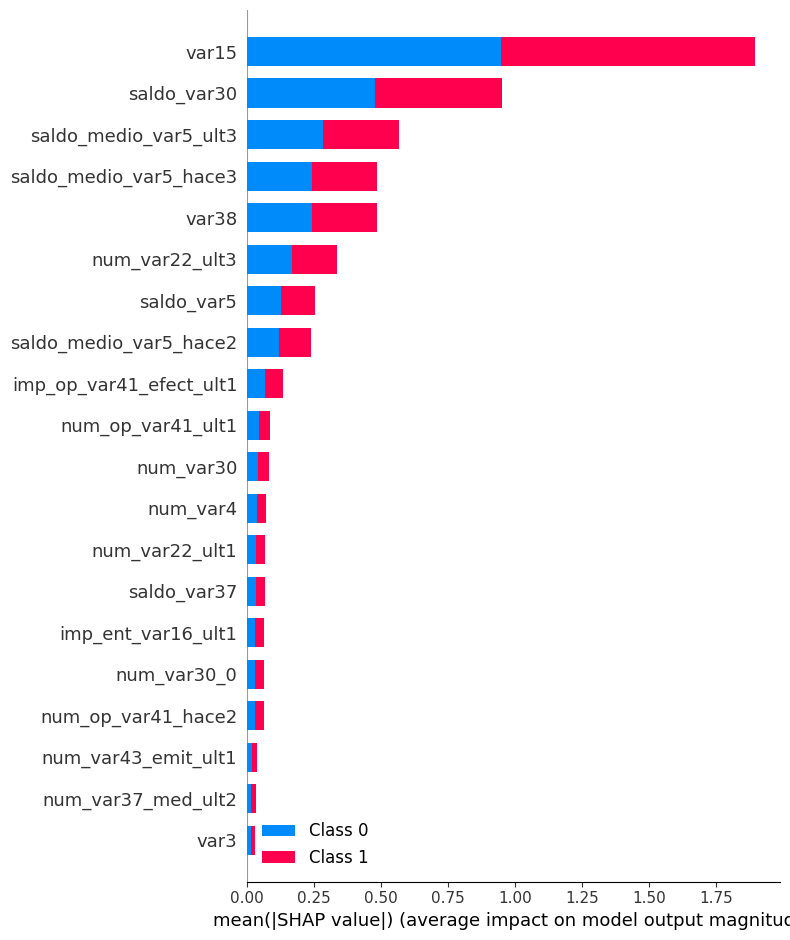

In [36]:
shap.summary_plot(shap_values, dfValCLF, feature_names=modelTransform.get_feature_names_out())

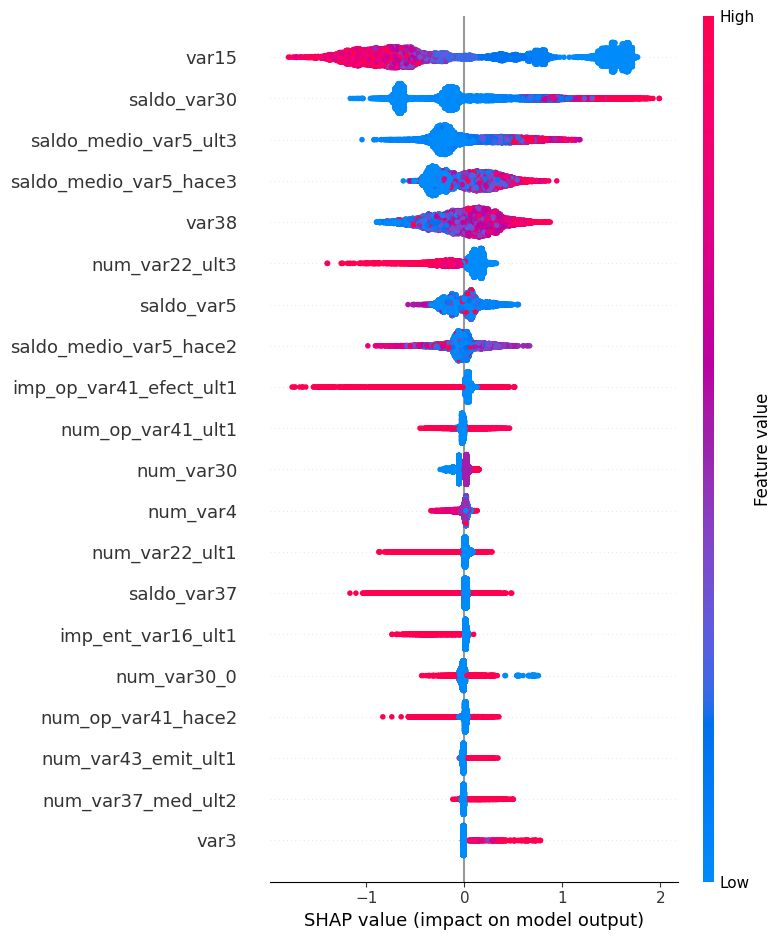

In [38]:
shap.summary_plot(shap_values[0], dfValCLF, feature_names=modelTransform.get_feature_names_out())

# 2.0 - Notas (Case B)

In [39]:
yPred_prob = classifierLGBM.predict_proba(dfTestCLF)

A quantidade de publico no segmento 1 é menor pois trata-se do público categorizado como insatisfeito pelo modelo


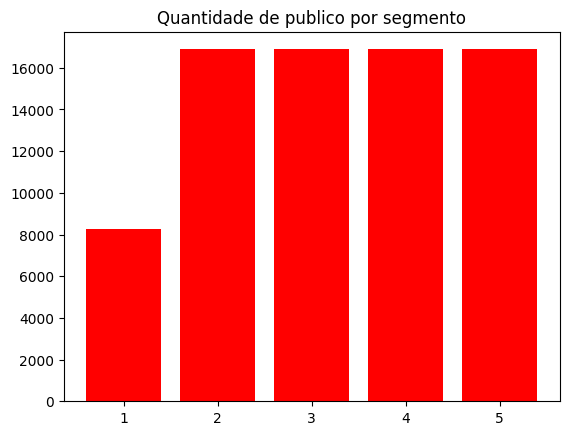

In [41]:
# ### Separar os clientes classificados como insatisfeitos pelo modelo
df_preds_1 =  pd.DataFrame(yPred_prob[yPred_prob[:,1] > 0.10][:,1] > 0.10*1)
df_preds_0 =  pd.DataFrame(yPred_prob[yPred_prob[:,1] <= 0.10][:,1])

# ### Dividir os registros classificados como satisfeitos em quartis baseados na probabilidade de serem insatisfeitos
decil_preds_0 = pd.qcut(df_preds_0[0].rank(method='first'), q = 4, labels = [2, 3, 4, 5])
pub_segmentado = np.concatenate((df_preds_1, decil_preds_0), axis=None)
segmentos, quantidade = np.unique(pub_segmentado, return_counts=True)

# ### Plot
plt.bar(segmentos, quantidade, color='red')
plt.title('Quantidade de publico por segmento');
print('A quantidade de publico no segmento 1 é menor pois trata-se do público categorizado como insatisfeito pelo modelo')


# 3.0 - Clustering (Agrupamento)

## 3.1 - Testar usando a normalização MinMaxScaler e todas as features

In [42]:
# ### Scaler feature for clustering
scaler = MinMaxScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
xTrainScaledcaled = scaler.transform(dfTrain)
xValScaled = scaler.transform(dfVal)

In [43]:
minCluster = 4
maxCluster = 20
wcss = []

for nClusters in range(minCluster, maxCluster):
    
    # ### Train kmeans model
    kmeanModel = KMeans(n_clusters = nClusters, random_state = 424)
    kmeanModel.fit(xTrainScaledcaled)
    
    # ### Predict
    pred = kmeanModel.predict(xTrainScaledcaled)

    # ### Compute WCSS (Elbow)
    wcss.append(kmeanModel.inertia_)
    
    # ### Compute silhouette score
    score = silhouette_score(xTrainScaledcaled, pred)
   
    print(f'Silhouette Score for {nClusters} clusters: {score:.5f}')

Silhouette Score for 4 clusters: 0.41210
Silhouette Score for 5 clusters: 0.45119
Silhouette Score for 6 clusters: 0.45528
Silhouette Score for 7 clusters: 0.46472
Silhouette Score for 8 clusters: 0.46705
Silhouette Score for 9 clusters: 0.47738
Silhouette Score for 10 clusters: 0.48125
Silhouette Score for 11 clusters: 0.48165
Silhouette Score for 12 clusters: 0.48298
Silhouette Score for 13 clusters: 0.47825
Silhouette Score for 14 clusters: 0.48113
Silhouette Score for 15 clusters: 0.48421
Silhouette Score for 16 clusters: 0.48760
Silhouette Score for 17 clusters: 0.48318
Silhouette Score for 18 clusters: 0.47488
Silhouette Score for 19 clusters: 0.46802


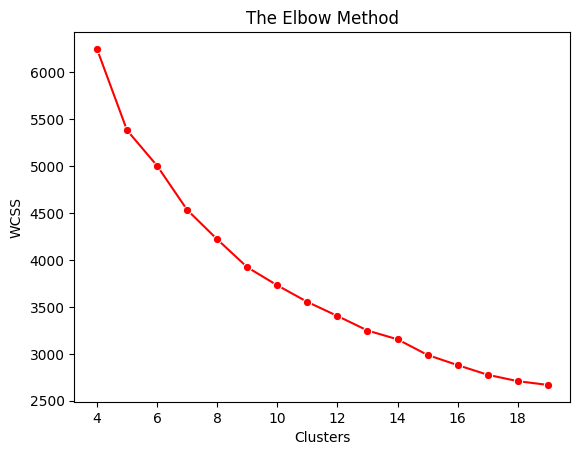

In [44]:
mycenters = pd.DataFrame({'Clusters' : range(minCluster, maxCluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [45]:
def optimalNumberClusters(wcss):
    x1, y1 = 4, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+4
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + 4
    
print(f'Melhor número de clusters de acordo com o método Elbow: {optimalNumberClusters(wcss)}')

Melhor número de clusters de acordo com o método Elbow: 9


### 3.1.0 - Com base no Elbow

In [46]:
# ### Avaliar com base no método Elbow
best_k = 9

model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target    0   1  Ganho  Perda  Lucro
labels                                   
6            129   4    360   1290   -930
2            359  28   2520   3590  -1070
8            190   0      0   1900  -1900


### 3.1.1 - Com base na Silhueta Score

In [48]:
best_k = 16
    
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('Top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target    0    1  Ganho  Perda  Lucro
labels                                    
14           741  151  13590   7410   6180
12            72    7    630    720    -90
2             36    2    180    360   -180


## 3.2 - Testar usando a normalização MinMaxScaler e removendo as variáveis binárias

In [49]:
dfTrain.nunique()

var3                         195
var15                         81
imp_ent_var16_ult1           513
imp_op_var41_efect_ult1      289
ind_var1_0                     2
ind_var25_cte                  2
num_var4                       7
num_op_var41_hace2            48
num_op_var41_ult1             58
num_var30_0                   11
num_var30                      5
num_var37_med_ult2            15
saldo_var5                  9592
saldo_var30                13848
saldo_var37                 3301
imp_aport_var13_hace3        187
num_var22_ult1                15
num_var22_ult3                29
num_meses_var8_ult3            4
num_var43_emit_ult1           10
saldo_medio_var5_hace2     12021
saldo_medio_var5_hace3      5801
saldo_medio_var5_ult3      14479
saldo_medio_var8_hace3       304
var38                      46608
dtype: int64

In [50]:
dfTrainDrop = dfTrain.drop(labels=['ind_var1_0', 'ind_var25_cte'] , axis=1, inplace = False)
dfValDrop = dfVal.drop(labels=['ind_var1_0', 'ind_var25_cte'] , axis=1, inplace = False)

In [51]:
# ### Scaler feature for clustering
scaler = MinMaxScaler()
scaler.fit(dfTrainDrop)

# ### Apply in train and val
xTrainScaledcaled = scaler.transform(dfTrainDrop)
xValScaled = scaler.transform(dfValDrop)

In [52]:
minCluster = 4
maxCluster = 20
wcss = []

for nClusters in range(minCluster, maxCluster):
    
    # ### Train kmeans model
    kmeanModel = KMeans(n_clusters = nClusters, random_state = 424)
    kmeanModel.fit(xTrainScaledcaled)
    
    # ### Predict
    pred = kmeanModel.predict(xTrainScaledcaled)

    # ### Compute WCSS (Elbow)
    wcss.append(kmeanModel.inertia_)
    
    # ### Compute silhouette score
    score = silhouette_score(xTrainScaledcaled, pred)
   
    print(f'Silhouette Score for {nClusters} clusters: {score:.5f}')

Silhouette Score for 4 clusters: 0.44045
Silhouette Score for 5 clusters: 0.45464
Silhouette Score for 6 clusters: 0.45883
Silhouette Score for 7 clusters: 0.46494
Silhouette Score for 8 clusters: 0.47442
Silhouette Score for 9 clusters: 0.47550
Silhouette Score for 10 clusters: 0.47827
Silhouette Score for 11 clusters: 0.47923
Silhouette Score for 12 clusters: 0.46112
Silhouette Score for 13 clusters: 0.47594
Silhouette Score for 14 clusters: 0.45441
Silhouette Score for 15 clusters: 0.46725
Silhouette Score for 16 clusters: 0.45540
Silhouette Score for 17 clusters: 0.46540
Silhouette Score for 18 clusters: 0.45371
Silhouette Score for 19 clusters: 0.46829


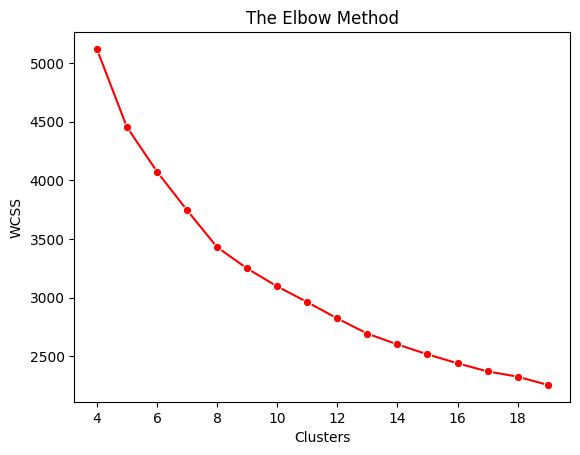

In [53]:
mycenters = pd.DataFrame({'Clusters' : range(minCluster, maxCluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [54]:
def optimalNumberClusters(wcss):
    x1, y1 = 4, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+4
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + 4
    
print(f'Melhor número de clusters de acordo com o método Elbow: {optimalNumberClusters(wcss)}')

Melhor número de clusters de acordo com o método Elbow: 9


### 3.2.0 - Com base no Elbow 

In [55]:
best_k = 9
   
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target    0    1  Ganho  Perda  Lucro
labels                                    
5            765  153  13770   7650   6120
2            266   25   2250   2660   -410
8            196    0      0   1960  -1960


### 3.2.1 - Com base na Silhueta Score

In [56]:
best_k = 11
    
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target    0    1  Ganho  Perda  Lucro
labels                                    
9            765  152  13680   7650   6030
3            268   25   2250   2680   -430
10            49    0      0    490   -490


## 3.3 - Testar usando a normalização MinMaxScaler e removendo as variáveis com menos de 10 valores distitos

In [57]:
dfTrainDrop = dfTrain.drop(labels=['ind_var1_0', 'ind_var25_cte', 'num_var4', 'num_var30', 'num_meses_var8_ult3'] , axis=1, inplace = False)
dfValDrop = dfVal.drop(labels=['ind_var1_0', 'ind_var25_cte', 'num_var4', 'num_var30', 'num_meses_var8_ult3'] , axis=1, inplace = False)

In [58]:
# ### Scaler feature for clustering
scaler = MinMaxScaler()
scaler.fit(dfTrainDrop)

# ### Apply in train and val
xTrainScaledcaled = scaler.transform(dfTrainDrop)
xValScaled = scaler.transform(dfValDrop)

In [59]:
minCluster = 4
maxCluster = 20
wcss = []

for nClusters in range(minCluster, maxCluster):
    
    # ### Train kmeans model
    kmeanModel = KMeans(n_clusters = nClusters, random_state = 424)
    kmeanModel.fit(xTrainScaledcaled)
    
    # ### Predict
    pred = kmeanModel.predict(xTrainScaledcaled)

    # ### Compute WCSS (Elbow)
    wcss.append(kmeanModel.inertia_)
    
    # ### Compute silhouette score
    score = silhouette_score(xTrainScaledcaled, pred)
   
    print(f'Silhouette Score for {nClusters} clusters: {score:.5f}')

Silhouette Score for 4 clusters: 0.51516
Silhouette Score for 5 clusters: 0.50807
Silhouette Score for 6 clusters: 0.51836
Silhouette Score for 7 clusters: 0.45302
Silhouette Score for 8 clusters: 0.45344
Silhouette Score for 9 clusters: 0.45542
Silhouette Score for 10 clusters: 0.46519
Silhouette Score for 11 clusters: 0.46825
Silhouette Score for 12 clusters: 0.47396
Silhouette Score for 13 clusters: 0.42154
Silhouette Score for 14 clusters: 0.43230
Silhouette Score for 15 clusters: 0.42011
Silhouette Score for 16 clusters: 0.42333
Silhouette Score for 17 clusters: 0.42669
Silhouette Score for 18 clusters: 0.43623
Silhouette Score for 19 clusters: 0.38977


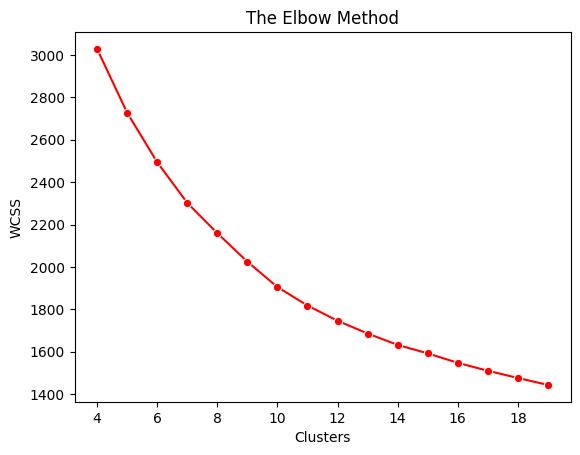

In [60]:
mycenters = pd.DataFrame({'Clusters' : range(minCluster, maxCluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [61]:
def optimalNumberClusters(wcss):
    x1, y1 = 4, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+4
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + 4
    
print(f'Melhor número de clusters de acordo com o método Elbow: {optimalNumberClusters(wcss)}')

Melhor número de clusters de acordo com o método Elbow: 10


### 3.3.0 - Com base no Elbow 

In [62]:
best_k = 10
    
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target    0   1  Ganho  Perda  Lucro
labels                                   
0             47   0      0    470   -470
7            191  11    990   1910   -920
2            112   1     90   1120  -1030


### 3.3.1 - Com base na Silhueta Score

In [63]:
best_k = 6
    
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target    0   1  Ganho  Perda  Lucro
labels                                   
4            205   0      0   2050  -2050
3            227   2    180   2270  -2090
5            693  49   4410   6930  -2520


## 3.4 - Testar usando a normalização StandardScaler e todas as features

In [64]:
# ### Scaler feature for clustering
scaler = StandardScaler()
scaler.fit(dfTrain)

# ### Apply in train and val
xTrainScaledcaled = scaler.transform(dfTrain)
xValScaled = scaler.transform(dfVal)

In [65]:
minCluster = 4
maxCluster = 20
wcss = []

for nClusters in range(minCluster, maxCluster):

    # ### Train Kmeans
    kmeanModel = KMeans(n_clusters = nClusters, random_state = 424)
    kmeanModel.fit(xTrainScaledcaled)
    
    # ### Predict
    pred = kmeanModel.predict(xTrainScaledcaled)

    # ### Compute WCSS (Elbow)
    wcss.append(kmeanModel.inertia_)
    
    # ### Compute silhouette score
    score = silhouette_score(xTrainScaledcaled, pred)
   
    print(f'Silhouette Score for {nClusters} clusters: {score:.5f}')

Silhouette Score for 4 clusters: 0.55689
Silhouette Score for 5 clusters: 0.47182
Silhouette Score for 6 clusters: 0.47033
Silhouette Score for 7 clusters: 0.29392
Silhouette Score for 8 clusters: 0.30331
Silhouette Score for 9 clusters: 0.31257
Silhouette Score for 10 clusters: 0.31135
Silhouette Score for 11 clusters: 0.31865
Silhouette Score for 12 clusters: 0.31964
Silhouette Score for 13 clusters: 0.32963
Silhouette Score for 14 clusters: 0.34128
Silhouette Score for 15 clusters: 0.33520
Silhouette Score for 16 clusters: 0.34512
Silhouette Score for 17 clusters: 0.35005
Silhouette Score for 18 clusters: 0.35248
Silhouette Score for 19 clusters: 0.35756


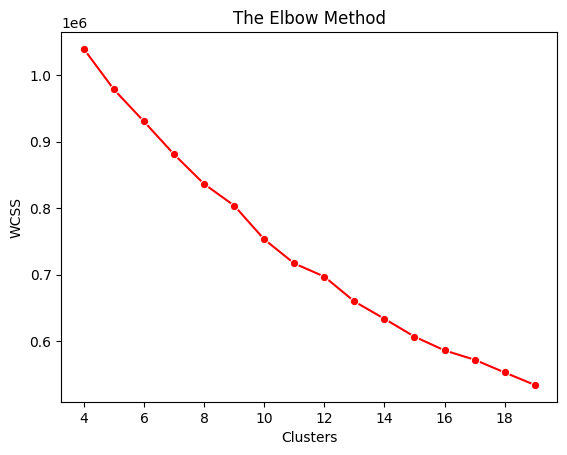

In [66]:
mycenters = pd.DataFrame({'Clusters' : range(minCluster, maxCluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [67]:
def optimalNumberClusters(wcss):
    x1, y1 = 4, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+4
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + 4
    
print(f'Melhor número de clusters de acordo com o método Elbow: {optimalNumberClusters(wcss)}')

Melhor número de clusters de acordo com o método Elbow: 11


### 3.4.0 - Com base no Elbow 

In [68]:
best_k = 11
    
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target   0  1  Ganho  Perda  Lucro
labels                                 
9            14  1     90    140    -50
4            29  0      0    290   -290
8            40  1     90    400   -310


### 3.4.1 - Com base na Silhueta Score

In [69]:
best_k = 4
    
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target     0   1  Ganho  Perda  Lucro
labels                                    
3              87   0      0    870   -870
2             728  53   4770   7280  -2510
1            1101  12   1080  11010  -9930


## 3.5 - Testar usando a normalização yeo-johnson e todas as features

In [70]:
# ### Scaler feature for clustering
scaler = PowerTransformer(method='yeo-johnson')
scaler.fit(dfTrain)

# ### Apply in train and val
xTrainScaledcaled = scaler.transform(dfTrain)
xValScaled = scaler.transform(dfVal)

In [71]:
minCluster = 4
maxCluster = 20
wcss = []

for nClusters in range(minCluster, maxCluster):
    
    # ### Train kmeans model
    kmeanModel = KMeans(n_clusters = nClusters, random_state = 424)
    kmeanModel.fit(xTrainScaledcaled)
    
    # ### Predict
    pred = kmeanModel.predict(xTrainScaledcaled)

    # ### Compute WCSS (Elbow)
    wcss.append(kmeanModel.inertia_)
    
    # ### Compute silhouette score
    score = silhouette_score(xTrainScaledcaled, pred)
   
    print(f'Silhouette Score for {nClusters} clusters: {score:.5f}')

Silhouette Score for 4 clusters: 0.38468
Silhouette Score for 5 clusters: 0.36831
Silhouette Score for 6 clusters: 0.22247
Silhouette Score for 7 clusters: 0.23478
Silhouette Score for 8 clusters: 0.23233
Silhouette Score for 9 clusters: 0.25225
Silhouette Score for 10 clusters: 0.26064
Silhouette Score for 11 clusters: 0.26528
Silhouette Score for 12 clusters: 0.27640
Silhouette Score for 13 clusters: 0.26719
Silhouette Score for 14 clusters: 0.27106
Silhouette Score for 15 clusters: 0.27821
Silhouette Score for 16 clusters: 0.27976
Silhouette Score for 17 clusters: 0.19728
Silhouette Score for 18 clusters: 0.20478
Silhouette Score for 19 clusters: 0.26083


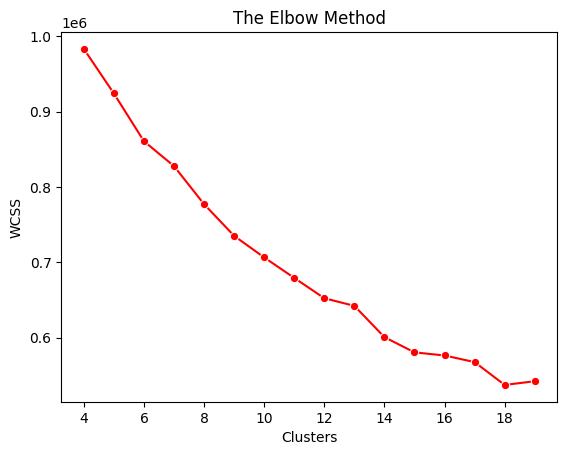

In [72]:
mycenters = pd.DataFrame({'Clusters' : range(minCluster, maxCluster), 'WCSS' : wcss})
sns.lineplot(x = 'Clusters', y = 'WCSS', data = mycenters, marker="o", color='red')
plt.title('The Elbow Method')
plt.show()

In [73]:
def optimalNumberClusters(wcss):
    x1, y1 = 4, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+4
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + 4
    
print(f'Melhor número de clusters de acordo com o método Elbow: {optimalNumberClusters(wcss)}')

Melhor número de clusters de acordo com o método Elbow: 10


### 3.5.0 - Com base no Elbow 

In [75]:
best_k = 10
    
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target    0   1  Ganho  Perda  Lucro
labels                                   
7             93   7    630    930   -300
4            267  24   2160   2670   -510
0            357   2    180   3570  -3390


### 3.5.1 - Com base na Silhueta Score

In [76]:
best_k = 4
    
model = KMeans(n_clusters = best_k, random_state = 424)
model.fit(xTrainScaledcaled)

cluster = model.predict(xValScaled)

df_cluster = pd.DataFrame({'cluster': cluster}).join(yVal)
df_cluster.columns = ['labels','true_target']

data = pd.crosstab(df_cluster['labels'],df_cluster['true_target'])

data['Ganho'] = data [1]*90 
data['Perda'] = data[0]*10
data['Lucro'] = data['Ganho'] - data['Perda']
print('top 3 clusters para o kmeans')
print(data.sort_values(by='Lucro', ascending=False).head(3))

top 3 clusters para o kmeans
true_target     0   1  Ganho  Perda  Lucro
labels                                    
2             355  31   2790   3550   -760
3            1430  10    900  14300 -13400
0            2259  71   6390  22590 -16200
